In [1]:
%matplotlib inline


# 08. Pre-stack (AVO) inversion
Pre-stack inversion represents one step beyond post-stack inversion in that
not only the profile of acoustic impedance can be inferred from seismic data,
rather a set of elastic parameters is estimated from pre-stack data
(i.e., angle gathers) using the information contained in the so-called
AVO (amplitude versus offset) response. Such elastic parameters represent
vital information for more sophisticated geophysical subsurface
characterization than it would be possible to achieve working with
post-stack seismic data.

In this tutorial, the :py:class:`pylops.avo.prestack.PrestackLinearModelling`
operator is used for modelling of both 1d and 2d synthetic pre-stack seismic
data using 1d profiles or 2d models of different subsurface elastic parameters
(P-wave velocity, S-wave velocity, and density) as input.

\begin{align}d(t, \theta) = w(t) * \sum_{i=1}^N G_i(t, \theta) \frac{\mathrm{d}\ln m_i(t)}{\mathrm{d}t}\end{align}

where $\mathbf{m}(t)=[V_P(t), V_S(t), \rho(t)]$ is a vector containing
three elastic parameters at time $t$, $G_i(t, \theta)$ are the
coefficients of the AVO parametrization used to model pre-stack data
and $w(t)$ is the time domain seismic wavelet.
In compact form:

\begin{align}\mathbf{d}= \mathbf{W} \mathbf{G} \mathbf{D} \mathbf{m}\end{align}

where $\mathbf{W}$ is a convolution operator, $\mathbf{G}$ is
the AVO modelling operator, $\mathbf{D}$ is a block-diagonal
derivative operator, and $\mathbf{m}$ is the input model.
Subsequently the elastic parameters are estimated via the
:py:class:`pylops.avo.prestack.PrestackInversion` module.
Once again, a two-steps inversion strategy can also be used to deal
with the case of noisy data.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import filtfilt

import pylops
from pylops.utils.wavelets import ricker

plt.close("all")
np.random.seed(0)

Let's start with a 1d example. A synthetic profile of acoustic impedance
is created and data is modelled using both the dense and linear operator
version of :py:class:`pylops.avo.prestack.PrestackLinearModelling` operator



In [3]:
# sphinx_gallery_thumbnail_number = 5

# model
nt0 = 301
dt0 = 0.004

t0 = np.arange(nt0) * dt0
vp = 1200 + np.arange(nt0) + filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 80, nt0))
vs = 600 + vp / 2 + filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 20, nt0))
rho = 1000 + vp + filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 30, nt0))
vp[131:] += 500
vs[131:] += 200
rho[131:] += 100
vsvp = 0.5
m = np.stack((np.log(vp), np.log(vs), np.log(rho)), axis=1)

# background model
nsmooth = 50
mback = filtfilt(np.ones(nsmooth) / float(nsmooth), 1, m, axis=0)

# angles
ntheta = 21
thetamin, thetamax = 0, 40
theta = np.linspace(thetamin, thetamax, ntheta)

# wavelet
ntwav = 41
wav = ricker(t0[: ntwav // 2 + 1], 15)[0]

# lop
PPop = pylops.avo.prestack.PrestackLinearModelling(
    wav, theta, vsvp=vsvp, nt0=nt0, linearization="akirich"
)

# dense
PPop_dense = pylops.avo.prestack.PrestackLinearModelling(
    wav, theta, vsvp=vsvp, nt0=nt0, linearization="akirich", explicit=True
)

# data lop
dPP = PPop * m.ravel()
dPP = dPP.reshape(nt0, ntheta)

# data dense
dPP_dense = PPop_dense * m.T.ravel()
dPP_dense = dPP_dense.reshape(ntheta, nt0).T

# noisy data
dPPn_dense = dPP_dense + np.random.normal(0, 1e-2, dPP_dense.shape)

We can now invert our data and retrieve elastic profiles for both noise-free
and noisy data using :py:class:`pylops.avo.prestack.PrestackInversion`.



In [4]:
# dense
minv_dense, dPP_dense_res = pylops.avo.prestack.PrestackInversion(
    dPP_dense,
    theta,
    wav,
    m0=mback,
    linearization="akirich",
    explicit=True,
    returnres=True,
    **dict(cond=1e-10)
)

# lop
minv, dPP_res = pylops.avo.prestack.PrestackInversion(
    dPP,
    theta,
    wav,
    m0=mback,
    linearization="akirich",
    explicit=False,
    returnres=True,
    **dict(damp=1e-10, iter_lim=2000)
)

# dense noisy
minv_dense_noise, dPPn_dense_res = pylops.avo.prestack.PrestackInversion(
    dPPn_dense,
    theta,
    wav,
    m0=mback,
    linearization="akirich",
    explicit=True,
    returnres=True,
    **dict(cond=1e-1)
)

# lop noisy (with vertical smoothing)
minv_noise, dPPn_res = pylops.avo.prestack.PrestackInversion(
    dPPn_dense,
    theta,
    wav,
    m0=mback,
    linearization="akirich",
    explicit=False,
    epsR=5e-1,
    returnres=True,
    **dict(damp=1e-1, iter_lim=100)
)

The data, inverted models and residuals are now displayed.



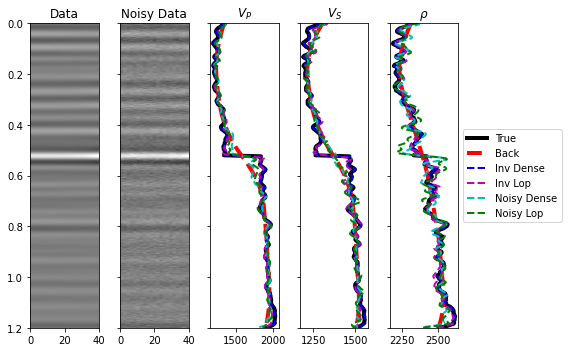

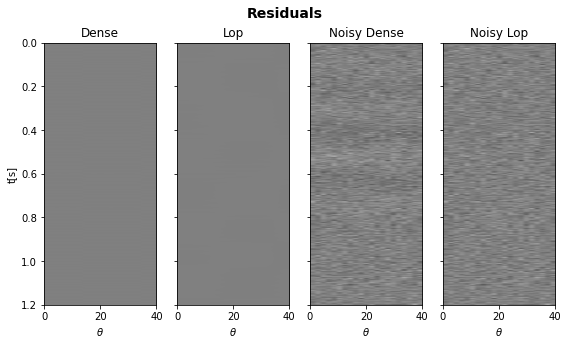

In [5]:
# data and model
fig, (axd, axdn, axvp, axvs, axrho) = plt.subplots(1, 5, figsize=(8, 5), sharey=True)
axd.imshow(
    dPP_dense,
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-np.abs(dPP_dense).max(),
    vmax=np.abs(dPP_dense).max(),
)
axd.set_title("Data")
axd.axis("tight")
axdn.imshow(
    dPPn_dense,
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-np.abs(dPP_dense).max(),
    vmax=np.abs(dPP_dense).max(),
)
axdn.set_title("Noisy Data")
axdn.axis("tight")
axvp.plot(vp, t0, "k", lw=4, label="True")
axvp.plot(np.exp(mback[:, 0]), t0, "--r", lw=4, label="Back")
axvp.plot(np.exp(minv_dense[:, 0]), t0, "--b", lw=2, label="Inv Dense")
axvp.plot(np.exp(minv[:, 0]), t0, "--m", lw=2, label="Inv Lop")
axvp.plot(np.exp(minv_dense_noise[:, 0]), t0, "--c", lw=2, label="Noisy Dense")
axvp.plot(np.exp(minv_noise[:, 0]), t0, "--g", lw=2, label="Noisy Lop")
axvp.set_title(r"$V_P$")
axvs.plot(vs, t0, "k", lw=4, label="True")
axvs.plot(np.exp(mback[:, 1]), t0, "--r", lw=4, label="Back")
axvs.plot(np.exp(minv_dense[:, 1]), t0, "--b", lw=2, label="Inv Dense")
axvs.plot(np.exp(minv[:, 1]), t0, "--m", lw=2, label="Inv Lop")
axvs.plot(np.exp(minv_dense_noise[:, 1]), t0, "--c", lw=2, label="Noisy Dense")
axvs.plot(np.exp(minv_noise[:, 1]), t0, "--g", lw=2, label="Noisy Lop")
axvs.set_title(r"$V_S$")
axrho.plot(rho, t0, "k", lw=4, label="True")
axrho.plot(np.exp(mback[:, 2]), t0, "--r", lw=4, label="Back")
axrho.plot(np.exp(minv_dense[:, 2]), t0, "--b", lw=2, label="Inv Dense")
axrho.plot(np.exp(minv[:, 2]), t0, "--m", lw=2, label="Inv Lop")
axrho.plot(np.exp(minv_dense_noise[:, 2]), t0, "--c", lw=2, label="Noisy Dense")
axrho.plot(np.exp(minv_noise[:, 2]), t0, "--g", lw=2, label="Noisy Lop")
axrho.set_title(r"$\rho$")
axrho.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axd.axis("tight")
plt.tight_layout()

# residuals
fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
fig.suptitle("Residuals", fontsize=14, fontweight="bold", y=0.95)
im = axs[0].imshow(
    dPP_dense_res,
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-0.1,
    vmax=0.1,
)
axs[0].set_title("Dense")
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel("t[s]")
axs[0].axis("tight")
axs[1].imshow(
    dPP_res,
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-0.1,
    vmax=0.1,
)
axs[1].set_title("Lop")
axs[1].set_xlabel(r"$\theta$")
axs[1].axis("tight")
axs[2].imshow(
    dPPn_dense_res,
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-0.1,
    vmax=0.1,
)
axs[2].set_title("Noisy Dense")
axs[2].set_xlabel(r"$\theta$")
axs[2].axis("tight")
axs[3].imshow(
    dPPn_res,
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-0.1,
    vmax=0.1,
)
axs[3].set_title("Noisy Lop")
axs[3].set_xlabel(r"$\theta$")
axs[3].axis("tight")
plt.tight_layout()
plt.subplots_adjust(top=0.85)

Finally before moving to the 2d example, we consider the case when both PP
and PS data are available. A joint PP-PS inversion can be easily solved
as follows.



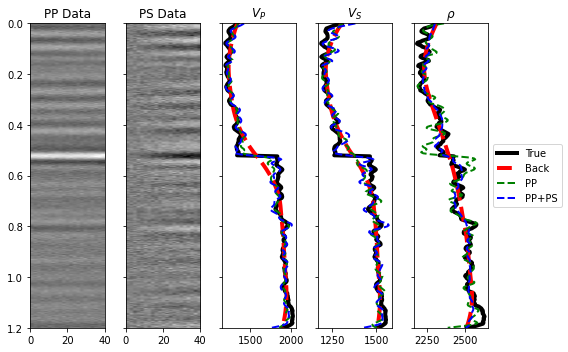

In [6]:
PSop = pylops.avo.prestack.PrestackLinearModelling(
    2 * wav, theta, vsvp=vsvp, nt0=nt0, linearization="ps"
)
PPPSop = pylops.VStack((PPop, PSop))

# data
dPPPS = PPPSop * m.ravel()
dPPPS = dPPPS.reshape(2, nt0, ntheta)

dPPPSn = dPPPS + np.random.normal(0, 1e-2, dPPPS.shape)

# Invert
minvPPSP, dPPPS_res = pylops.avo.prestack.PrestackInversion(
    dPPPS,
    theta,
    [wav, 2 * wav],
    m0=mback,
    linearization=["fatti", "ps"],
    epsR=5e-1,
    returnres=True,
    **dict(damp=1e-1, iter_lim=100)
)

# Data and model
fig, (axd, axdn, axvp, axvs, axrho) = plt.subplots(1, 5, figsize=(8, 5), sharey=True)
axd.imshow(
    dPPPSn[0],
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-np.abs(dPPPSn[0]).max(),
    vmax=np.abs(dPPPSn[0]).max(),
)
axd.set_title("PP Data")
axd.axis("tight")
axdn.imshow(
    dPPPSn[1],
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-np.abs(dPPPSn[1]).max(),
    vmax=np.abs(dPPPSn[1]).max(),
)
axdn.set_title("PS Data")
axdn.axis("tight")
axvp.plot(vp, t0, "k", lw=4, label="True")
axvp.plot(np.exp(mback[:, 0]), t0, "--r", lw=4, label="Back")
axvp.plot(np.exp(minv_noise[:, 0]), t0, "--g", lw=2, label="PP")
axvp.plot(np.exp(minvPPSP[:, 0]), t0, "--b", lw=2, label="PP+PS")
axvp.set_title(r"$V_P$")
axvs.plot(vs, t0, "k", lw=4, label="True")
axvs.plot(np.exp(mback[:, 1]), t0, "--r", lw=4, label="Back")
axvs.plot(np.exp(minv_noise[:, 1]), t0, "--g", lw=2, label="PP")
axvs.plot(np.exp(minvPPSP[:, 1]), t0, "--b", lw=2, label="PP+PS")
axvs.set_title(r"$V_S$")
axrho.plot(rho, t0, "k", lw=4, label="True")
axrho.plot(np.exp(mback[:, 2]), t0, "--r", lw=4, label="Back")
axrho.plot(np.exp(minv_noise[:, 2]), t0, "--g", lw=2, label="PP")
axrho.plot(np.exp(minvPPSP[:, 2]), t0, "--b", lw=2, label="PP+PS")
axrho.set_title(r"$\rho$")
axrho.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axd.axis("tight")
plt.tight_layout()

We move now to a 2d example. First of all the model is loaded and
data generated.



In [7]:
# model
inputfile = "../testdata/avo/poststack_model.npz"

model = np.load(inputfile)
x, z = model["x"][::6] / 1000.0, model["z"][:300] / 1000.0
nx, nz = len(x), len(z)
m = 1000 * model["model"][:300, ::6]

mvp = m.copy()
mvs = m / 2
mrho = m / 3 + 300
m = np.log(np.stack((mvp, mvs, mrho), axis=1))

# smooth model
nsmoothz, nsmoothx = 30, 25
mback = filtfilt(np.ones(nsmoothz) / float(nsmoothz), 1, m, axis=0)
mback = filtfilt(np.ones(nsmoothx) / float(nsmoothx), 1, mback, axis=2)

# dense operator
PPop_dense = pylops.avo.prestack.PrestackLinearModelling(
    wav,
    theta,
    vsvp=vsvp,
    nt0=nz,
    spatdims=(nx,),
    linearization="akirich",
    explicit=True,
)

# lop operator
PPop = pylops.avo.prestack.PrestackLinearModelling(
    wav, theta, vsvp=vsvp, nt0=nz, spatdims=(nx,), linearization="akirich"
)

# data
dPP = PPop_dense * m.swapaxes(0, 1).ravel()
dPP = dPP.reshape(ntheta, nz, nx).swapaxes(0, 1)
dPPn = dPP + np.random.normal(0, 5e-2, dPP.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../testdata/avo/poststack_model.npz'

Finally we perform the same 4 different inversions as in the post-stack
tutorial (see `sphx_glr_tutorials_poststack.py` for more details).



In [ ]:
# dense inversion with noise-free data
minv_dense = pylops.avo.prestack.PrestackInversion(
    dPP, theta, wav, m0=mback, explicit=True, simultaneous=False
)

# dense inversion with noisy data
minv_dense_noisy = pylops.avo.prestack.PrestackInversion(
    dPPn, theta, wav, m0=mback, explicit=True, epsI=4e-2, simultaneous=False
)

# spatially regularized lop inversion with noisy data
minv_lop_reg = pylops.avo.prestack.PrestackInversion(
    dPPn,
    theta,
    wav,
    m0=minv_dense_noisy,
    explicit=False,
    epsR=1e1,
    **dict(damp=np.sqrt(1e-4), iter_lim=20)
)

# blockiness promoting inversion with noisy data
minv_blocky = pylops.avo.prestack.PrestackInversion(
    dPPn,
    theta,
    wav,
    m0=mback,
    explicit=False,
    epsR=0.4,
    epsRL1=0.1,
    **dict(mu=0.1, niter_outer=3, niter_inner=3, iter_lim=5, damp=1e-3)
)

Let's now visualize the inverted elastic parameters for the different
scenarios



In [ ]:
def plotmodel(
    axs,
    m,
    x,
    z,
    vmin,
    vmax,
    params=("VP", "VS", "Rho"),
    cmap="gist_rainbow",
    title=None,
):
    """Quick visualization of model"""
    for ip, param in enumerate(params):
        axs[ip].imshow(
            m[:, ip], extent=(x[0], x[-1], z[-1], z[0]), vmin=vmin, vmax=vmax, cmap=cmap
        )
        axs[ip].set_title("%s - %s" % (param, title))
        axs[ip].axis("tight")
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[2].get_yticklabels(), visible=False)


# data
fig = plt.figure(figsize=(8, 9))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 1), sharey=ax2)
ax4 = plt.subplot2grid((2, 3), (1, 2), sharey=ax2)
ax1.imshow(
    dPP[:, 0], cmap="gray", extent=(x[0], x[-1], z[-1], z[0]), vmin=-0.4, vmax=0.4
)
ax1.vlines(
    [x[nx // 5], x[nx // 2], x[4 * nx // 5]],
    ymin=z[0],
    ymax=z[-1],
    colors="w",
    linestyles="--",
)
ax1.set_xlabel("x [km]")
ax1.set_ylabel("z [km]")
ax1.set_title(r"Stack ($\theta$=0)")
ax1.axis("tight")
ax2.imshow(
    dPP[:, :, nx // 5],
    cmap="gray",
    extent=(theta[0], theta[-1], z[-1], z[0]),
    vmin=-0.4,
    vmax=0.4,
)
ax2.set_xlabel(r"$\theta$")
ax2.set_ylabel("z [km]")
ax2.set_title(r"Gather (x=%.2f)" % x[nx // 5])
ax2.axis("tight")
ax3.imshow(
    dPP[:, :, nx // 2],
    cmap="gray",
    extent=(theta[0], theta[-1], z[-1], z[0]),
    vmin=-0.4,
    vmax=0.4,
)
ax3.set_xlabel(r"$\theta$")
ax3.set_title(r"Gather (x=%.2f)" % x[nx // 2])
ax3.axis("tight")
ax4.imshow(
    dPP[:, :, 4 * nx // 5],
    cmap="gray",
    extent=(theta[0], theta[-1], z[-1], z[0]),
    vmin=-0.4,
    vmax=0.4,
)
ax4.set_xlabel(r"$\theta$")
ax4.set_title(r"Gather (x=%.2f)" % x[4 * nx // 5])
ax4.axis("tight")
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

# noisy data
fig = plt.figure(figsize=(8, 9))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 1), sharey=ax2)
ax4 = plt.subplot2grid((2, 3), (1, 2), sharey=ax2)
ax1.imshow(
    dPPn[:, 0], cmap="gray", extent=(x[0], x[-1], z[-1], z[0]), vmin=-0.4, vmax=0.4
)
ax1.vlines(
    [x[nx // 5], x[nx // 2], x[4 * nx // 5]],
    ymin=z[0],
    ymax=z[-1],
    colors="w",
    linestyles="--",
)
ax1.set_xlabel("x [km]")
ax1.set_ylabel("z [km]")
ax1.set_title(r"Noisy Stack ($\theta$=0)")
ax1.axis("tight")
ax2.imshow(
    dPPn[:, :, nx // 5],
    cmap="gray",
    extent=(theta[0], theta[-1], z[-1], z[0]),
    vmin=-0.4,
    vmax=0.4,
)
ax2.set_xlabel(r"$\theta$")
ax2.set_ylabel("z [km]")
ax2.set_title(r"Gather (x=%.2f)" % x[nx // 5])
ax2.axis("tight")
ax3.imshow(
    dPPn[:, :, nx // 2],
    cmap="gray",
    extent=(theta[0], theta[-1], z[-1], z[0]),
    vmin=-0.4,
    vmax=0.4,
)
ax3.set_title(r"Gather (x=%.2f)" % x[nx // 2])
ax3.set_xlabel(r"$\theta$")
ax3.axis("tight")
ax4.imshow(
    dPPn[:, :, 4 * nx // 5],
    cmap="gray",
    extent=(theta[0], theta[-1], z[-1], z[0]),
    vmin=-0.4,
    vmax=0.4,
)
ax4.set_xlabel(r"$\theta$")
ax4.set_title(r"Gather (x=%.2f)" % x[4 * nx // 5])
ax4.axis("tight")
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)

# inverted models
fig, axs = plt.subplots(6, 3, figsize=(8, 19))
fig.suptitle("Model", fontsize=12, fontweight="bold", y=0.95)
plotmodel(axs[0], m, x, z, m.min(), m.max(), title="True")
plotmodel(axs[1], mback, x, z, m.min(), m.max(), title="Back")
plotmodel(axs[2], minv_dense, x, z, m.min(), m.max(), title="Dense")
plotmodel(axs[3], minv_dense_noisy, x, z, m.min(), m.max(), title="Dense noisy")
plotmodel(axs[4], minv_lop_reg, x, z, m.min(), m.max(), title="Lop regularized")
plotmodel(axs[5], minv_blocky, x, z, m.min(), m.max(), title="Lop blocky")
plt.tight_layout()
plt.subplots_adjust(top=0.92)

fig, axs = plt.subplots(1, 3, figsize=(8, 7))
for ip, param in enumerate(["VP", "VS", "Rho"]):
    axs[ip].plot(m[:, ip, nx // 2], z, "k", lw=4, label="True")
    axs[ip].plot(mback[:, ip, nx // 2], z, "--r", lw=4, label="Back")
    axs[ip].plot(minv_dense[:, ip, nx // 2], z, "--b", lw=2, label="Inv Dense")
    axs[ip].plot(
        minv_dense_noisy[:, ip, nx // 2], z, "--m", lw=2, label="Inv Dense noisy"
    )
    axs[ip].plot(
        minv_lop_reg[:, ip, nx // 2], z, "--g", lw=2, label="Inv Lop regularized"
    )
    axs[ip].plot(minv_blocky[:, ip, nx // 2], z, "--y", lw=2, label="Inv Lop blocky")
    axs[ip].set_title(param)
    axs[ip].invert_yaxis()
axs[2].legend(loc=8, fontsize="small")
plt.tight_layout()

While the background model ``m0`` has been provided in all the examples so
far, it is worth showing that the module
:py:class:`pylops.avo.prestack.PrestackInversion` can also produce so-called
relative elastic parameters (i.e., variations from an average medium
property) when the background model ``m0`` is not available.



In [ ]:
dminv = pylops.avo.prestack.PrestackInversion(
    dPP, theta, wav, m0=None, explicit=True, simultaneous=False
)

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
plotmodel(axs, dminv, x, z, -dminv.max(), dminv.max(), cmap="seismic", title="relative")

fig, axs = plt.subplots(1, 3, figsize=(8, 7))
for ip, param in enumerate(["VP", "VS", "Rho"]):
    axs[ip].plot(dminv[:, ip, nx // 2], z, "k", lw=2)
    axs[ip].set_title(param)
    axs[ip].invert_yaxis()